In [70]:
import numpy as np 
import matplotlib.pyplot as plt
from datasets import load_dataset
import json
import evaluate

[2024-06-26 23:03:46,986] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [34]:
with open('../MATH_aug/AugMATH_part1.jsonl', 'r') as json_file:
    json_list = list(json_file)

with open('../MATH_aug/AugMATH_part2.jsonl', 'r') as json_file:
    json_list += list(json_file)

train_questions = []
train_answers = []
for json_str in json_list:
    result = json.loads(json_str)
    train_questions.append(result["query"])
    train_answers.append(result["response"])
    
train_questions = np.array(train_questions)
train_answers = np.array(train_answers)

In [64]:
easy10000_train_accs = []

for epoch in range(3, 7):
    acc = (np.load(f"../ckpts/math_aug_fft_easy10000_{epoch}epochs/train_subsample_answer_types5.npy")==0).mean()
    easy10000_train_accs.append(acc)

In [12]:
easy10000_train_accs

[0.4288, 0.5152, 0.5992, 0.683]

In [20]:


train_part1_accs = (np.load("../ckpts/math_aug_fft_full/train_part1_answer_types5.npy")==0).sum(axis=-1)
train_part2_accs = (np.load("../ckpts/math_aug_fft_full/train_part2_answer_types5.npy")==0).sum(axis=-1)
train_accs = np.concatenate([train_part1_accs, train_part2_accs])

easy_idxs =np.where(train_accs>=3)[0]
medium_idxs = np.where((train_accs>=1) & (train_accs<3))[0]
hard_idxs = np.where(train_accs==0)[0]

In [21]:



rand10000_easy_train_accs = []
rand10000_medium_train_accs = []
rand10000_hard_train_accs = []

for epoch in range(3, 7):
    subsample_idxs = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/subsample_idxs.npy")[:1000]
    
    accs_all = (np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answer_types5.npy")==0).mean(axis=-1)
        
    acc_easy = accs_all[np.where(np.isin(subsample_idxs, easy_idxs))[0]].mean()
    rand10000_easy_train_accs.append(acc_easy)
    
    acc_medium = accs_all[np.where(np.isin(subsample_idxs, medium_idxs))[0]].mean()
    rand10000_medium_train_accs.append(acc_medium)
    
    acc_hard = accs_all[np.where(np.isin(subsample_idxs, hard_idxs))[0]].mean()
    rand10000_hard_train_accs.append(acc_hard)

Text(0.5, 1.0, 'MATH 10000 examples')

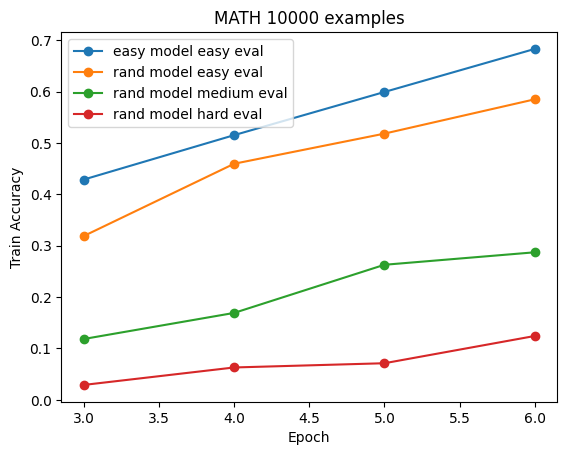

In [26]:
plt.plot(range(3, 7), easy10000_train_accs, "o-", label="easy model easy eval")
plt.plot(range(3, 7), rand10000_easy_train_accs, "o-", label="rand model easy eval")
plt.plot(range(3, 7), rand10000_medium_train_accs, "o-", label="rand model medium eval")
plt.plot(range(3, 7), rand10000_hard_train_accs, "o-", label="rand model hard eval")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.title("MATH 10000 examples")

In [71]:
rouge = evaluate.load('rouge')

# easy10000_train_memorization_rate = []
easy10000_train_rouge = []

for epoch in range(3, 7):


    subsample_idxs = np.load(f"../ckpts/math_aug_fft_easy10000_{epoch}epochs/subsample_idxs.npy")[:1000]
    train_answers_subsampled = np.array([train_answers[subsample_idxs], train_answers[subsample_idxs], train_answers[subsample_idxs], train_answers[subsample_idxs], train_answers[subsample_idxs]]).transpose().flatten()
    sampled_answers = np.load(f"../ckpts/math_aug_fft_easy10000_{epoch}epochs/train_subsample_answers5.npy").flatten()
    
    
    
    correct_subsample_idxs = np.where((np.load(f"../ckpts/math_aug_fft_easy10000_{epoch}epochs/train_subsample_answer_types5.npy")==0).flatten())[0]
    train_answers_subsampled_correct = train_answers_subsampled[correct_subsample_idxs]
    sampled_answers_correct = sampled_answers[correct_subsample_idxs]
    
    # easy10000_train_memorization_rate.append(np.equal(train_answers_subsampled_correct, sampled_answers_correct).mean())    
    results = rouge.compute(predictions=sampled_answers_correct, references=train_answers_subsampled_correct, use_aggregator=False)
    easy10000_train_rouge.append(results['rougeL'])

In [74]:
rand10000_easy_train_rouge = []

for epoch in range(3, 7):
    subsample_idxs = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/subsample_idxs.npy")[:1000]
    
    
    subsample_subsample_idxs = np.where(np.isin(subsample_idxs, easy_idxs))[0]
    train_answers_subsampled = np.array([train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]]]).transpose().flatten()
    sampled_answers = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answers5.npy")[subsample_subsample_idxs].flatten()
    
    correct_subsample_idxs = np.where((np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answer_types5.npy")==0)[[subsample_subsample_idxs]].flatten())[0]
    train_answers_subsampled_correct = train_answers_subsampled[correct_subsample_idxs]
    sampled_answers_correct = sampled_answers[correct_subsample_idxs]
    
    results = rouge.compute(predictions=sampled_answers_correct, references=train_answers_subsampled_correct, use_aggregator=False)
    rand10000_easy_train_rouge.append(results['rougeL'])

Text(0.5, 1.0, 'MATH 10000 epoch 6')

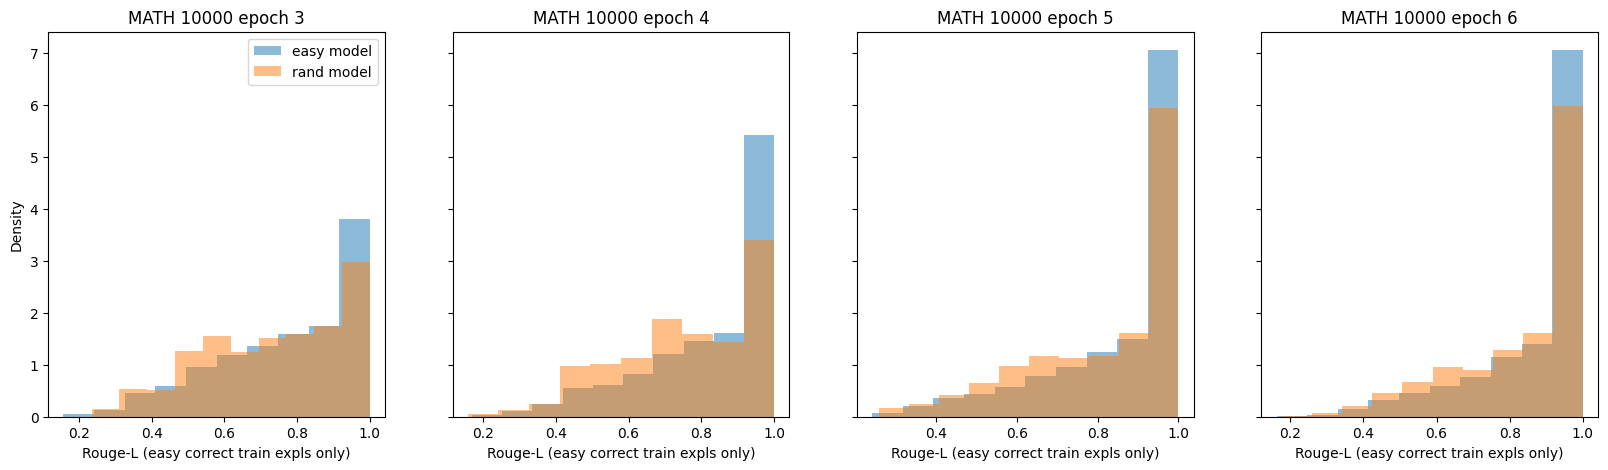

In [81]:
# make 4 subplots

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

axs[0].hist(easy10000_train_rouge[0], alpha=0.5, label="easy model", density=True)
axs[0].hist(rand10000_easy_train_rouge[0], alpha=0.5, label="rand model", density=True)
axs[0].set_xlabel("Rouge-L (easy correct train expls only)")
axs[0].legend()
axs[0].set_ylabel("Density")
axs[0].set_title("MATH 10000 epoch 3")

axs[1].hist(easy10000_train_rouge[1], alpha=0.5, label="easy model", density=True)
axs[1].hist(rand10000_easy_train_rouge[1], alpha=0.5, label="rand model", density=True)
axs[1].set_xlabel("Rouge-L (easy correct train expls only)")
axs[1].set_title("MATH 10000 epoch 4")


axs[2].hist(easy10000_train_rouge[2], alpha=0.5, label="easy model", density=True)
axs[2].hist(rand10000_easy_train_rouge[2], alpha=0.5, label="rand model", density=True)
axs[2].set_xlabel("Rouge-L (easy correct train expls only)")
axs[2].set_title("MATH 10000 epoch 5")


axs[3].hist(easy10000_train_rouge[3], alpha=0.5, label="easy model", density=True)
axs[3].hist(rand10000_easy_train_rouge[3], alpha=0.5, label="rand model", density=True)
axs[3].set_xlabel("Rouge-L (easy correct train expls only)")
axs[3].set_title("MATH 10000 epoch 6")


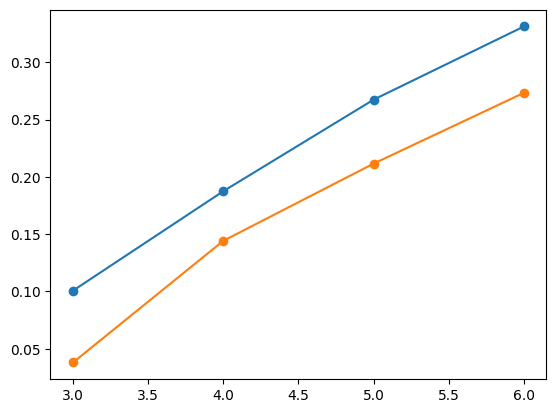

In [68]:
plt.plot(range(3, 7), easy10000_train_memorization_rate, "o-", label="easy model")
plt.plot(range(3, 7), rand10000_train_memorization_rate, "o-", label="rand model")



In [47]:
easy10000_train_memorization_rate

[0.10074626865671642, 0.1875, 0.2673564753004005, 0.33118594436310395]

In [56]:
rand10000_easy_train_memorization_rate = []
rand10000_medium_train_memorization_rate = []
rand10000_hard_train_memorization_rate = []


for epoch in range(3, 7):
    subsample_idxs = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/subsample_idxs.npy")[:1000]
    
    
    subsample_subsample_idxs = np.where(np.isin(subsample_idxs, easy_idxs))[0]
    train_answers_subsampled = np.array([train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]]]).transpose().flatten()
    sampled_answers = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answers5.npy")[subsample_subsample_idxs].flatten()
    
    correct_subsample_idxs = np.where((np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answer_types5.npy")==0)[[subsample_subsample_idxs]].flatten())[0]
    train_answers_subsampled_correct = train_answers_subsampled[correct_subsample_idxs]
    sampled_answers_correct = sampled_answers[correct_subsample_idxs]
    
    rand10000_easy_train_memorization_rate.append(np.equal(train_answers_subsampled_correct, sampled_answers_correct).mean())    
    
    
    
    subsample_subsample_idxs = np.where(np.isin(subsample_idxs, medium_idxs))[0]
    train_answers_subsampled = np.array([train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]]]).transpose().flatten()
    sampled_answers = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answers5.npy")[subsample_subsample_idxs].flatten()
    
    correct_subsample_idxs = np.where((np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answer_types5.npy")==0)[[subsample_subsample_idxs]].flatten())[0]
    train_answers_subsampled_correct = train_answers_subsampled[correct_subsample_idxs]
    sampled_answers_correct = sampled_answers[correct_subsample_idxs]
    
    rand10000_medium_train_memorization_rate.append(np.equal(train_answers_subsampled_correct, sampled_answers_correct).mean())    



    subsample_subsample_idxs = np.where(np.isin(subsample_idxs, hard_idxs))[0]
    train_answers_subsampled = np.array([train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]], train_answers[subsample_idxs[subsample_subsample_idxs]]]).transpose().flatten()
    sampled_answers = np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answers5.npy")[subsample_subsample_idxs].flatten()
    
    correct_subsample_idxs = np.where((np.load(f"../ckpts/math_aug_fft_rand10000_{epoch}epochs/train_subsample_answer_types5.npy")==0)[[subsample_subsample_idxs]].flatten())[0]
    train_answers_subsampled_correct = train_answers_subsampled[correct_subsample_idxs]
    sampled_answers_correct = sampled_answers[correct_subsample_idxs]
    
    rand10000_hard_train_memorization_rate.append(np.equal(train_answers_subsampled_correct, sampled_answers_correct).mean())    

Text(0.5, 1.0, 'MATH 10000 examples')

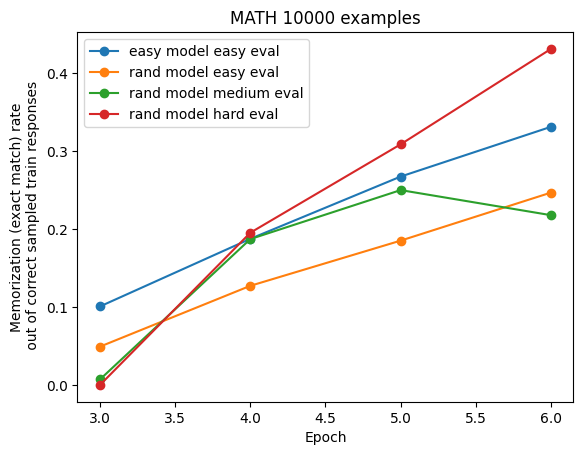

In [59]:
plt.plot(range(3, 7), easy10000_train_memorization_rate, "o-", label="easy model easy eval")
plt.plot(range(3, 7), rand10000_easy_train_memorization_rate, "o-", label="rand model easy eval")
plt.plot(range(3, 7), rand10000_medium_train_memorization_rate, "o-", label="rand model medium eval")
plt.plot(range(3, 7), rand10000_hard_train_memorization_rate, "o-", label="rand model hard eval")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Memorization (exact match) rate\n out of correct sampled train responses")
plt.title("MATH 10000 examples")

In [60]:
easy10000_train_memorization_rate= np.array(easy10000_train_memorization_rate)
rand10000_easy_train_memorization_rate = np.array(rand10000_easy_train_memorization_rate)
rand10000_medium_train_memorization_rate = np.array(rand10000_medium_train_memorization_rate)
rand10000_hard_train_memorization_rate = np.array(rand10000_hard_train_memorization_rate)

easy10000_train_accs = np.array(easy10000_train_accs)
rand10000_easy_train_accs = np.array(rand10000_easy_train_accs)
rand10000_medium_train_accs = np.array(rand10000_medium_train_accs)
rand10000_hard_train_accs = np.array(rand10000_hard_train_accs)

In [63]:
rand10000_easy_train_accs

array([0.31891892, 0.45951743, 0.51815718, 0.58492754])

In [49]:
rand10000_easy_train_memorization_rate

[0.04915254237288136,
 0.12718786464410736,
 0.18514644351464435,
 0.24677898909811694]

In [51]:
rand10000_medium_train_memorization_rate

[0.0070921985815602835, 0.18716577540106952, 0.25, 0.21782178217821782]

In [52]:
rand10000_hard_train_memorization_rate

[0.0, 0.1953125, 0.3087248322147651, 0.4311594202898551]

In [44]:
easy10000_train_memorization_rate

[0.10074626865671642, 0.1875, 0.2673564753004005, 0.33118594436310395]

In [39]:
np.array([train_answers[subsample_idxs], train_answers[subsample_idxs], train_answers[subsample_idxs], train_answers[subsample_idxs], train_answers[subsample_idxs]]).shape

(5, 1000)

In [22]:
rand10000_medium_train_accs

[0.1184873949579832,
 0.1692307692307692,
 0.26291079812206575,
 0.28720379146919434]

In [23]:
rand10000_hard_train_accs

[0.029081632653061226,
 0.06305418719211824,
 0.07129186602870813,
 0.12432432432432433]